In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

In [2]:
cpu_temp = pd.read_csv("../data/cpu-temp.csv", header=None, names=["time", "cpu_temp"])
fan_speed = pd.read_csv("../data/fan-speed.csv", header=None, names=["time", "fan_speed"])
inlet_temp = pd.read_csv("../data/inlet-temp.csv", header=None, names=["time", "inlet_temp"])
it_power = pd.read_csv("../data/it-power.csv", header=None, names=["time", "it_power"])

In [3]:
def process_dataframe(df, time_col, value_col):
    df[time_col] = df[time_col].astype(int)

    min_time = df[time_col].min()
    max_time = df[time_col].max()
    full_index = pd.DataFrame({time_col: np.arange(min_time, max_time + 1)})

    df_full = pd.merge(full_index, df, on=time_col, how='left')
    df_full[value_col] = df_full[value_col].interpolate(method="polynomial", order=2)

    return df_full

cpu_temp_new = process_dataframe(cpu_temp, "time", "cpu_temp")
fan_speed_new = process_dataframe(fan_speed, "time", "fan_speed")
inlet_temp_new = process_dataframe(inlet_temp, "time", "inlet_temp")
it_power_new = process_dataframe(it_power, "time", "it_power")

In [4]:
max_start = max(inlet_temp_new['time'].min(), cpu_temp_new['time'].min(), it_power_new['time'].min(), fan_speed_new['time'].min())
min_end = min(inlet_temp_new['time'].max(), cpu_temp_new['time'].max(), it_power_new['time'].max(), fan_speed_new['time'].max())

cpu_temp_filtered = cpu_temp_new[(cpu_temp_new['time'] >= max_start) & (cpu_temp_new['time'] <= min_end)]
inlet_temp_filtered = inlet_temp_new[(inlet_temp_new['time'] >= max_start) & (inlet_temp_new['time'] <= min_end)]
it_power_filtered = it_power_new[(it_power_new['time'] >= max_start) & (it_power_new['time'] <= min_end)]
fan_speed_filtered = fan_speed_new[(fan_speed_new['time'] >= max_start) & (fan_speed_new['time'] <= min_end)]

combined_df = pd.merge(cpu_temp_filtered, inlet_temp_filtered, on='time')
combined_df = pd.merge(combined_df, it_power_filtered, on='time')
combined_df = pd.merge(combined_df, fan_speed_filtered, on='time')

combined_df.head()

,time,cpu_temp,inlet_temp,it_power,fan_speed
0,4718,55.766525,22.468243,177.345436,3929.161963
1,4719,55.608490,22.468213,177.350546,3929.225715
2,4720,55.446706,22.468188,177.362315,3929.311931
3,4721,55.238044,22.468170,177.380743,3929.420613
4,4721,54.960208,22.468170,177.380743,3929.420613


In [5]:
df = combined_df.copy()
print(f"Shape of Final Dataframe = {df.shape}")

Shape of Final Dataframe = (4255, 5)


In [6]:
scalers = {
    'cpu_temp': StandardScaler(),
    'inlet_temp': StandardScaler(),
    'it_power': StandardScaler(),
    'fan_speed': StandardScaler()
}

df_scaled = pd.DataFrame(index=df.index)

for col, scaler in scalers.items():
    df_scaled[col] = scaler.fit_transform(df[[col]]).ravel()

In [7]:
def prepare_data(scaled_df, seq_length=8, k_step=24):

    # Define the input and output features
    features_cols = ['cpu_temp', 'inlet_temp', 'it_power']
    exogenous_col = 'fan_speed'
    output_col = 'cpu_temp'

    # Create sequences
    features = []
    exogenous = []
    outputs = []
    for i in range(len(scaled_df) - seq_length - k_step + 1):
        features.append(scaled_df[features_cols].iloc[i:i + seq_length].values)
        exogenous.append(scaled_df[exogenous_col].iloc[i + seq_length:i + seq_length + k_step].values)
        outputs.append(scaled_df[output_col].iloc[i + seq_length:i + seq_length + k_step].values)

    features = np.array(features)
    exogenous = np.array(exogenous).reshape(-1, k_step, 1)
    outputs = np.array(outputs).reshape(-1, k_step, 1)

    # Convert to PyTorch tensors
    features = torch.tensor(features, dtype=torch.float32)
    exogenous = torch.tensor(exogenous, dtype=torch.float32)
    outputs = torch.tensor(outputs, dtype=torch.float32)

    # Split into train and test
    split_ratio = 0.8
    split_index = int(len(features) * split_ratio)
    train_features, test_features = features[:split_index], features[split_index:]
    train_exogenous, test_exogenous = exogenous[:split_index], exogenous[split_index:]
    train_outputs, test_outputs = outputs[:split_index], outputs[split_index:]

    train_dataset = TensorDataset(train_features, train_exogenous, train_outputs)
    test_dataset = TensorDataset(test_features, test_exogenous, test_outputs)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    return train_loader, test_loader, outputs, split_index

In [8]:
# class DualInputAttentionLSTM(nn.Module):
#     def __init__(self, input_size, lstm_hidden_size, dense_hidden_size, k_step, fan_speed_impact=0.1):
#         super(DualInputAttentionLSTM, self).__init__()
#         self.lstm_hidden_size = lstm_hidden_size
#         self.k_step = k_step
#         self.input_size = input_size
#         self.fan_speed_impact = fan_speed_impact
#         self.lstm_attention = nn.MultiheadAttention(lstm_hidden_size, num_heads=1, batch_first=True)
#         self.lstm = nn.LSTM(input_size, lstm_hidden_size, batch_first=True)
#         self.dense1 = nn.Linear(lstm_hidden_size, dense_hidden_size)
#         self.relu = nn.ReLU()
#         self.dense2 = nn.Linear(dense_hidden_size, k_step)

#     def forward(self, x, exogenous_input_fan_speed):
#         batch_size, seq_len, feature_dim = x.shape
#         h_t = torch.zeros(1, batch_size, self.lstm_hidden_size, device=x.device)
#         c_t = torch.zeros(1, batch_size, self.lstm_hidden_size, device=x.device)
#         lstm_out, (h_t, c_t) = self.lstm(x, (h_t, c_t))
#         attn_output, _ = self.lstm_attention(lstm_out, lstm_out, lstm_out)
#         lstm_out = attn_output[:, -1, :]
#         dense1_out = self.relu(self.dense1(lstm_out))
#         outputs = self.dense2(dense1_out)
#         outputs = outputs - self.fan_speed_impact * exogenous_input_fan_speed.squeeze()
#         return outputs

In [9]:
import torch
import torch.nn as nn

class DualInputAttentionLSTM(nn.Module):
    def __init__(self, input_size, lstm_hidden_size, dense_hidden_size, k_step, fan_speed_impact_dim=32):
        super(DualInputAttentionLSTM, self).__init__()
        self.lstm_hidden_size = lstm_hidden_size
        self.k_step = k_step
        self.input_size = input_size

        # LSTM and Attention
        self.lstm_attention = nn.MultiheadAttention(lstm_hidden_size, num_heads=1, batch_first=True)
        self.lstm = nn.LSTM(input_size, lstm_hidden_size, batch_first=True)

        # Fan speed impact through an MLP (No ReLU to allow negative values)
        self.fan_speed_mlp = nn.Sequential(
            nn.Linear(1, fan_speed_impact_dim),  
            nn.Tanh(),  
            nn.Linear(fan_speed_impact_dim, lstm_hidden_size)  
        )

        # Fully connected layers
        self.dense1 = nn.Linear(lstm_hidden_size * 2, dense_hidden_size)  
        self.relu = nn.ReLU()
        self.dense2 = nn.Linear(dense_hidden_size, k_step)

    def forward(self, x, exogenous_input_fan_speed):
        batch_size, seq_len, feature_dim = x.shape

        # LSTM Processing
        h_t = torch.zeros(1, batch_size, self.lstm_hidden_size, device=x.device)
        c_t = torch.zeros(1, batch_size, self.lstm_hidden_size, device=x.device)
        lstm_out, (h_t, c_t) = self.lstm(x, (h_t, c_t))
        attn_output, _ = self.lstm_attention(lstm_out, lstm_out, lstm_out)
        lstm_features = attn_output[:, -1, :]  # Shape: (batch_size, lstm_hidden_size)

        # Apply inverse relationship transformation
        # fan_speed_transformed = 1/(1+ exogenous_input_fan_speed.mean(dim=1))  # Inverse transformation
        fan_speed_transformed = -1 * exogenous_input_fan_speed.mean(dim=1)  # Direct transformation
        # fan_speed_transformed = -exogenous_input_fan_speed.mean(dim=1)  # Alternative: Direct negation

        fan_speed_effect = self.fan_speed_mlp(fan_speed_transformed)
        fan_speed_effect = fan_speed_effect.squeeze(1)  

        # Concatenate features
        combined_features = torch.cat((lstm_features, fan_speed_effect), dim=1)  

        # Fully Connected Layers
        dense1_out = self.relu(self.dense1(combined_features))
        outputs = self.dense2(dense1_out)

        return outputs

In [10]:
def train_model(model, train_loader, test_loader, k_step, learning_rate=0.001, num_epochs=10):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)  # Reduce LR every 5 epochs

    history = {'train_loss': [], 'test_loss': []}

    # Function to compute loss
    def evaluate_loss(loader, model):
        model.eval()
        total_loss = 0
        with torch.no_grad():
            for batch_features, batch_exogenous, batch_outputs in loader:
                batch_exogenous = batch_exogenous.unsqueeze(-1)  # Ensure correct shape for fan speed
                outputs = model(batch_features, batch_exogenous)
                loss = criterion(outputs, batch_outputs.squeeze(-1))  # Fix dimension mismatch
                total_loss += loss.item()
        return total_loss / len(loader)

    train_loss = evaluate_loss(train_loader, model)
    test_loss = evaluate_loss(test_loader, model)

    history['train_loss'].append(train_loss)
    history['test_loss'].append(test_loss)
    print(f"Before Training: Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for batch_features, batch_exogenous, batch_outputs in train_loader:
            batch_exogenous = batch_exogenous.unsqueeze(-1)  # Ensure correct shape for fan speed
            
            optimizer.zero_grad()
            outputs = model(batch_features, batch_exogenous)
            loss = criterion(outputs, batch_outputs.squeeze(-1))  # Fix dimension mismatch
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)
        history['train_loss'].append(train_loss)

        # Evaluate test loss
        test_loss = evaluate_loss(test_loader, model)
        history['test_loss'].append(test_loss)

        # Adjust learning rate
        scheduler.step()

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")

    return model, history


In [11]:
# import torch
# import torch.nn as nn
# import torch.optim as optim

# def train_model(model, train_loader, test_loader, k_step, learning_rate=0.001, num_epochs=10):
#     criterion = nn.MSELoss()
#     optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
#     history = {'train_loss': [], 'test_loss': []}

#     # Compute and store the initial losses before training
#     model.eval()  # Set model to evaluation mode
#     train_loss = 0
#     with torch.no_grad():
#         for batch_features, batch_exogenous, batch_outputs in train_loader:

#             outputs = model(batch_features, batch_exogenous)
#             loss = criterion(outputs.unsqueeze(2), batch_outputs)  # Match dimensions
#             train_loss += loss.item()
#     train_loss /= len(train_loader)
#     history['train_loss'].append(train_loss)

#     test_loss = 0
#     with torch.no_grad():
#         for batch_features, batch_exogenous, batch_outputs in test_loader:

#             outputs = model(batch_features, batch_exogenous)
#             loss = criterion(outputs.unsqueeze(2), batch_outputs)  # Match dimensions
#             test_loss += loss.item()
#     test_loss /= len(test_loader)
#     history['test_loss'].append(test_loss)

#     print(f"Before Training: Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")

#     # Training loop
#     for epoch in range(num_epochs):
#         model.train()  # Set model to training mode
#         train_loss = 0
#         for batch_features, batch_exogenous, batch_outputs in train_loader:

#             optimizer.zero_grad()
#             outputs = model(batch_features, batch_exogenous)
#             loss = criterion(outputs.unsqueeze(2), batch_outputs)  # Unsqueeze to match dimensions
#             loss.backward()
#             optimizer.step()
#             train_loss += loss.item()
#         train_loss /= len(train_loader)
#         history['train_loss'].append(train_loss)

#         model.eval()  # Set model to evaluation mode
#         test_loss = 0
#         with torch.no_grad():
#             for batch_features, batch_exogenous, batch_outputs in test_loader:

#                 outputs = model(batch_features, batch_exogenous)
#                 loss = criterion(outputs.unsqueeze(2), batch_outputs)  # Match dimensions
#                 test_loss += loss.item()
#         test_loss /= len(test_loader)
#         history['test_loss'].append(test_loss)

#         print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")

#     return model, history


In [28]:
torch.manual_seed(42)
np.random.seed(42)

seq_length = 30
k_step = 30
input_size = 3  # cpu_temp, inlet_temp, it_power
lstm_hidden_size = 64
dense_hidden_size = 64
learning_rate = 0.001
num_epochs = 25

In [29]:
train_loader, test_loader, outputs, split_index = prepare_data(df_scaled, seq_length, k_step)

In [30]:
model = DualInputAttentionLSTM(input_size, lstm_hidden_size, dense_hidden_size, k_step)

In [31]:
trained_model, history = train_model(model, train_loader, test_loader, k_step, learning_rate, num_epochs)

Before Training: Train Loss: 0.7680, Test Loss: 1.9856
Epoch 1/25, Train Loss: 0.2187, Test Loss: 0.0623
Epoch 2/25, Train Loss: 0.0501, Test Loss: 0.0593
Epoch 3/25, Train Loss: 0.0448, Test Loss: 0.0626
Epoch 4/25, Train Loss: 0.0419, Test Loss: 0.0590
Epoch 5/25, Train Loss: 0.0394, Test Loss: 0.0584
Epoch 6/25, Train Loss: 0.0373, Test Loss: 0.0691
Epoch 7/25, Train Loss: 0.0354, Test Loss: 0.0689
Epoch 8/25, Train Loss: 0.0342, Test Loss: 0.0561
Epoch 9/25, Train Loss: 0.0327, Test Loss: 0.0509
Epoch 10/25, Train Loss: 0.0322, Test Loss: 0.0589
Epoch 11/25, Train Loss: 0.0309, Test Loss: 0.0561
Epoch 12/25, Train Loss: 0.0305, Test Loss: 0.0629
Epoch 13/25, Train Loss: 0.0301, Test Loss: 0.0622
Epoch 14/25, Train Loss: 0.0303, Test Loss: 0.0511
Epoch 15/25, Train Loss: 0.0299, Test Loss: 0.0532
Epoch 16/25, Train Loss: 0.0294, Test Loss: 0.0540
Epoch 17/25, Train Loss: 0.0292, Test Loss: 0.0592
Epoch 18/25, Train Loss: 0.0291, Test Loss: 0.0573
Epoch 19/25, Train Loss: 0.0289, Tes

In [32]:
# # plot the r2 and rmse with respect to k steps


# for k_step in range(5, 10, 15, 20, 25, 30, 35, 40, 45, 50):
#     train_loader, test_loader, outputs, split_index = prepare_data(df_scaled, seq_length, k_step=k_step)

#     model = DualInputAttentionLSTM(input_size, lstm_hidden_size, dense_hidden_size, k_step=k_step)

#     trained_model, history = train_model(model, train_loader, test_loader, k_step, learning_rate, num_epochs)

#     # plot the r2 and rmse with respect to k steps
#     plt.plot(history['train_loss'], label='Train Loss')
#     plt.plot(history['test_loss'], label='Test Loss')
#     plt.xlabel('Epochs')
#     plt.ylabel('Loss')
#     plt.title(f'Loss vs Epochs for k_step={k_step}')
#     plt.legend()
#     plt.show()

In [33]:
import os

save_path = "../models/model_direct_demo.pth"

os.makedirs(os.path.dirname(save_path), exist_ok=True)
torch.save(model.state_dict(), save_path)
print(f"Model saved to: {save_path}")

Model saved to: ../models/model_direct_demo.pth


In [34]:
def forecast_with_modified_exogenous(model, test_loader, scaler, k_step, modified_fan_speed):
    model.eval()
    
    # Get a single sample from the test loader
    batch_features, batch_exogenous, batch_outputs = next(iter(test_loader))

    # Use only the first sample in the batch
    features = batch_features[0].unsqueeze(0)  # Shape: [1, seq_length, input_size]
    exogenous = batch_exogenous[0].unsqueeze(0)  # Shape: [1, k_step, 1]
    
    # Modify the exogenous input (fan speed)
    modified_inputs = []
    for fan_speed in modified_fan_speed:
        modified_exogenous = torch.full_like(exogenous, fan_speed)
        modified_inputs.append(modified_exogenous)

    print(f"Original Exogenous Input (Fan Speed): {exogenous.flatten().cpu().numpy()}")

    modified_forecasts = []
    for modified_exogenous in modified_inputs:
        with torch.no_grad():
            forecast = model(features, modified_exogenous).cpu().numpy().flatten()
            modified_forecasts.append(forecast)
    with torch.no_grad():
        # Forecast using the original exogenous input
        original_forecast = model(features, exogenous).cpu().numpy().flatten()

    # Get actual values for comparison
    actual_values = batch_outputs[0].cpu().numpy().flatten()

    # **Inverse Transform Only the CPU Temp Values**
    original_forecast = scaler.inverse_transform(original_forecast.reshape(-1, 1)).flatten()
    for i, forecast in enumerate(modified_forecasts):
        modified_forecasts[i] = scaler.inverse_transform(forecast.reshape(-1, 1)).flatten()
    actual_values = scaler.inverse_transform(actual_values.reshape(-1, 1)).flatten()

    # **Plot the results**
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, k_step+1), actual_values, linestyle='-', label='Actual CPU Temp', color='black')
    plt.plot(range(1, k_step+1), original_forecast, linestyle='--', label='Original Forecast', color='blue')
    for i, modified_forecast in enumerate(modified_forecasts):
        plt.plot(range(1, k_step+1), modified_forecast, linestyle='--', label=f'Forecast with Fan Speed={modified_fan_speed[i]}',color='red')

    plt.xlabel("Time Steps")
    plt.ylabel("CPU Temperature")
    plt.title("Forecast Comparison with Modified Exogenous Input (Fan Speed)")
    plt.ylim(30, 60) 
    plt.legend()
    plt.show()


Original Exogenous Input (Fan Speed): [-0.90038687 -0.8999907  -0.8998914  -0.90013087 -0.90013087 -0.90013087
 -0.90013087 -0.90013087 -0.9007092  -0.9007092  -0.9016263  -0.9016263
 -0.9016263  -0.9016263  -0.9028822 ]


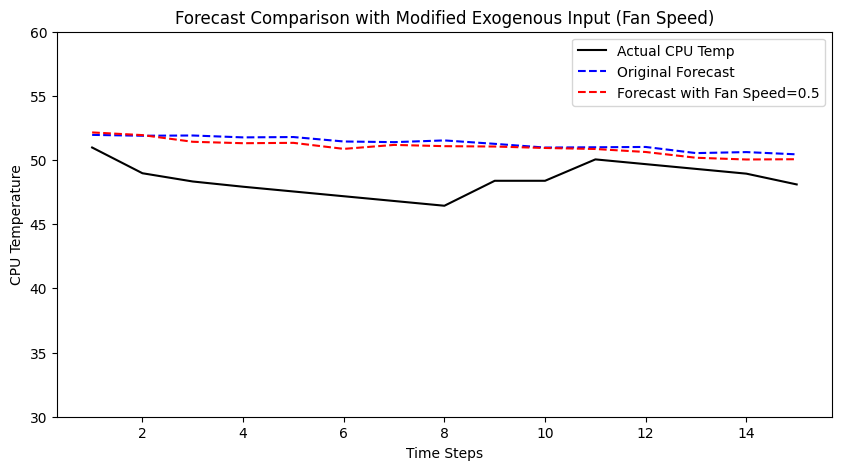

In [ ]:
forecast_with_modified_exogenous(model, test_loader, scalers["cpu_temp"], k_step, modified_fan_speed=[0.5])

In [35]:
import torch
import torch.nn as nn
import numpy as np
from sklearn.metrics import r2_score

def evaluate_model(model, test_loader, scaler, df, k_step, split_index):
    model.eval()
    criterion = nn.MSELoss()
    test_loss = 0
    predictions = []
    actuals = []

    with torch.no_grad():
        for batch_features, batch_exogenous, batch_outputs in test_loader:

            outputs = model(batch_features, batch_exogenous)
            loss = criterion(outputs, batch_outputs.squeeze(2))  # Ensure matching dimensions
            test_loss += loss.item()

            predictions.append(outputs.cpu().numpy())  # Move to CPU before converting to NumPy
            actuals.append(batch_outputs.cpu().numpy())

    test_loss /= len(test_loader)
    print(f"Test Loss: {test_loss:.4f}")

    # Convert predictions and actuals to numpy arrays
    predictions = np.concatenate(predictions, axis=0)  # Shape: (num_samples, k_step)
    actuals = np.concatenate(actuals, axis=0)  # Shape: (num_samples, k_step, 1)

    # Flatten actuals to (num_samples, k_step)
    actuals = actuals.squeeze(axis=2)

    # Create a dataframe using the original dataframe index
    actual_df = df.iloc[split_index:split_index + len(actuals)].copy()
    for i in range(k_step):
        actual_df[f'actual_cpu_temp_{i+1}'] = actuals[:, i]

    # Create a dataframe from predictions using the same index
    predictions_df = actual_df.copy()
    for i in range(k_step):
        predictions_df[f'predicted_cpu_temp_{i+1}'] = predictions[:, i]

    # Inverse scale the predicted and actual values
    for i in range(k_step):
        original_data = scaler.inverse_transform(
            predictions_df[['cpu_temp', 'inlet_temp', 'it_power', f'predicted_cpu_temp_{i+1}']].values
        )
        predictions_df[f'predicted_cpu_temp_{i+1}'] = original_data[:, -1]

        original_data_actual = scaler.inverse_transform(
            actual_df[['cpu_temp', 'inlet_temp', 'it_power', f'actual_cpu_temp_{i+1}']].values
        )
        predictions_df[f'actual_cpu_temp_{i+1}'] = original_data_actual[:, -1]

    predictions_df.reset_index(inplace=True)

    # Calculate R2 scores
    r2_scores = []
    for i in range(k_step):
        r2 = r2_score(predictions_df[f'actual_cpu_temp_{i+1}'], predictions_df[f'predicted_cpu_temp_{i+1}'])
        r2_scores.append(r2)
        print(f"R2 Score for Step {i+1}: {r2:.4f}")
    average_r2 = np.mean(r2_scores)
    print(f"Average R2 Score: {average_r2:.4f}")

    # Calculate RMSE scores
    rmse_scores = []
    for i in range(k_step):
        mse = np.mean((predictions_df[f'actual_cpu_temp_{i+1}'] - predictions_df[f'predicted_cpu_temp_{i+1}']) ** 2)
        rmse = np.sqrt(mse)
        rmse_scores.append(rmse)
        print(f"RMSE for Step {i+1}: {rmse:.4f}")
    average_rmse = np.mean(rmse_scores)
    print(f"Average RMSE: {average_rmse:.4f}")

    return predictions_df, test_loss, r2_scores, rmse_scores, average_r2, average_rmse


In [39]:
import matplotlib.pyplot as plt

def plot_results(predictions_df, history, k_step, r2_scores):
    for i in range(k_step):
        plt.figure(figsize=(12, 6))
        plt.plot(predictions_df[f'predicted_cpu_temp_{i+1}'], label=f'Predicted CPU Temp (°C)', color='red')
        plt.plot(predictions_df[f'actual_cpu_temp_{i+1}'], label=f'Actual CPU Temp (°C)', color='blue', alpha=0.6)
        
        # Increase font size for axis labels and title
        plt.xlabel('Time Step (s)', fontsize=14)
        plt.ylabel('CPU Temperature (°C)', fontsize=14)
        plt.title(f'Predicted vs Actual CPU Temperature - Step {i+1}, R2: {r2_scores[i]:.4f}', fontsize=16)
        
        # Increase font size for legend
        plt.legend(fontsize=12)
        plt.show()

    # Plotting training and test loss
    plt.figure(figsize=(12, 6))
    plt.plot(history['train_loss'], label='Training Loss', color='green')
    plt.plot(history['test_loss'], label='Test Loss', color='orange')
    
    # Increase font size for axis labels and title
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel('MSE Loss', fontsize=14)
    plt.title('Training vs Test Loss', fontsize=16)
    
    # Increase font size for legend
    plt.legend(fontsize=12)
    plt.show()


In [40]:
predictions_df, test_loss, r2_scores, rmse_scores, average_r2, average_rmse = evaluate_model(trained_model, test_loader, scalers["cpu_temp"], combined_df, k_step, split_index)

Test Loss: 0.0575
R2 Score for Step 1: 0.9570
R2 Score for Step 2: 0.9531
R2 Score for Step 3: 0.9523
R2 Score for Step 4: 0.9512
R2 Score for Step 5: 0.9499
R2 Score for Step 6: 0.9489
R2 Score for Step 7: 0.9479
R2 Score for Step 8: 0.9432
R2 Score for Step 9: 0.9454
R2 Score for Step 10: 0.9473
R2 Score for Step 11: 0.9441
R2 Score for Step 12: 0.9455
R2 Score for Step 13: 0.9450
R2 Score for Step 14: 0.9460
R2 Score for Step 15: 0.9448
R2 Score for Step 16: 0.9487
R2 Score for Step 17: 0.9472
R2 Score for Step 18: 0.9460
R2 Score for Step 19: 0.9488
R2 Score for Step 20: 0.9501
R2 Score for Step 21: 0.9496
R2 Score for Step 22: 0.9528
R2 Score for Step 23: 0.9537
R2 Score for Step 24: 0.9515
R2 Score for Step 25: 0.9504
R2 Score for Step 26: 0.9492
R2 Score for Step 27: 0.9516
R2 Score for Step 28: 0.9489
R2 Score for Step 29: 0.9495
R2 Score for Step 30: 0.9494
Average R2 Score: 0.9490
RMSE for Step 1: 1.7684
RMSE for Step 2: 1.8503
RMSE for Step 3: 1.8703
RMSE for Step 4: 1.8953


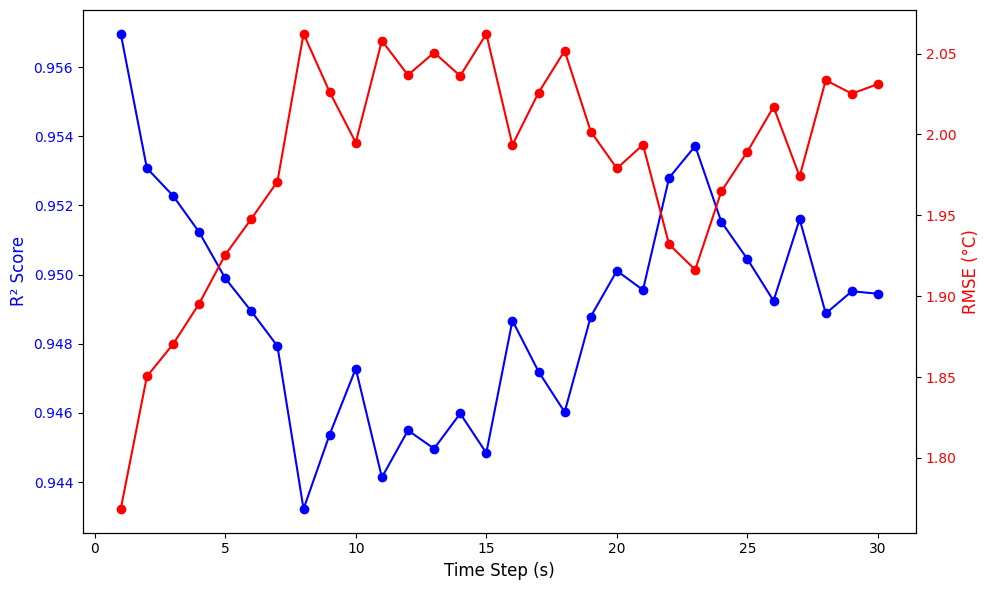

In [41]:
time_steps = np.arange(1, len(r2_scores) + 1)

fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot R²
ax1.plot(time_steps, r2_scores, 'o-', color='blue')
ax1.set_xlabel('Time Step (s)', fontsize=12)
ax1.set_ylabel('R² Score', color='blue', fontsize=12)
ax1.tick_params(axis='y', labelcolor='blue')

# Plot RMSE on the right axis
ax2 = ax1.twinx()
ax2.plot(time_steps, rmse_scores, 'o-', color='red')
ax2.set_ylabel('RMSE (°C)', color='red', fontsize=12)
ax2.tick_params(axis='y', labelcolor='red')

# Title and layout
# plt.title('Progression of R² and RMSE', fontsize=14)
plt.grid(False)
plt.tight_layout()
plt.show()

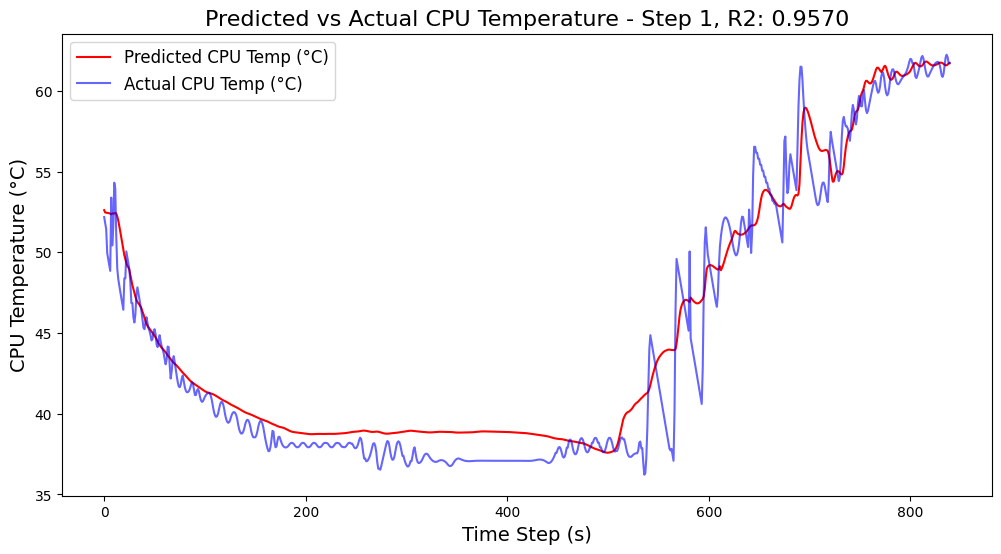

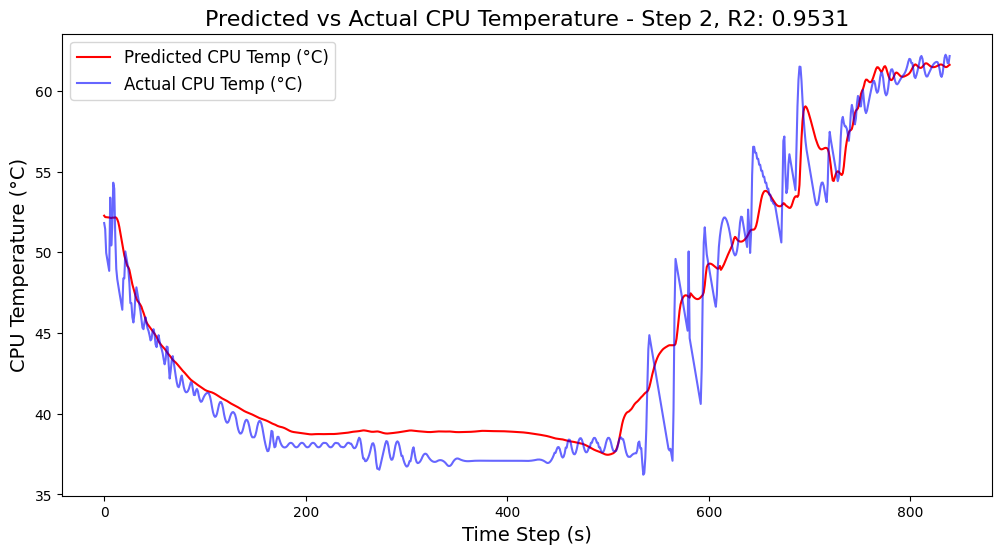

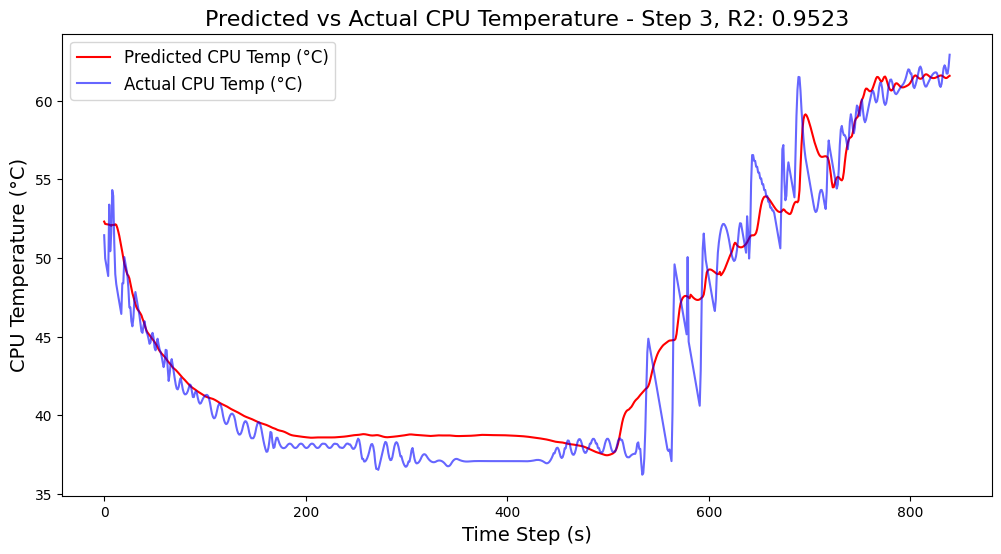

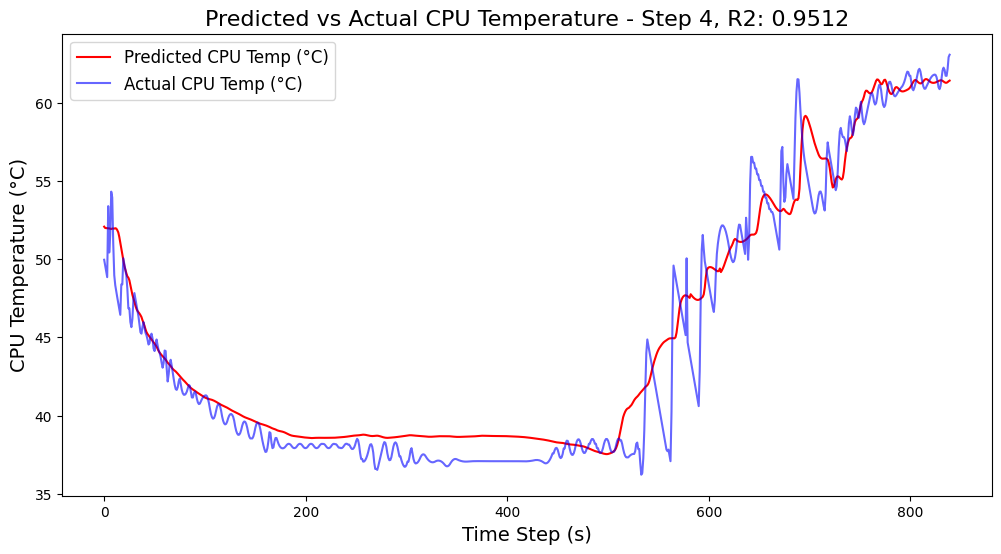

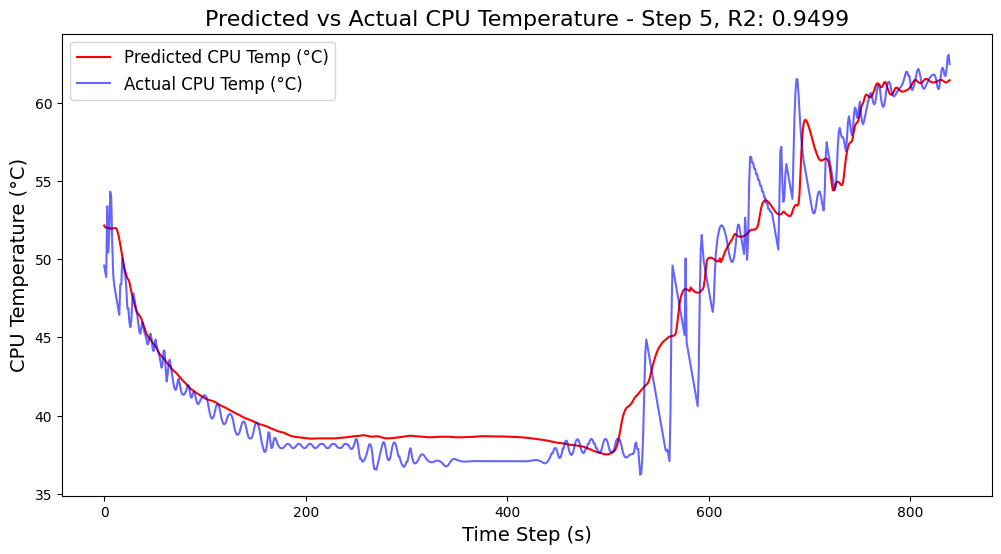

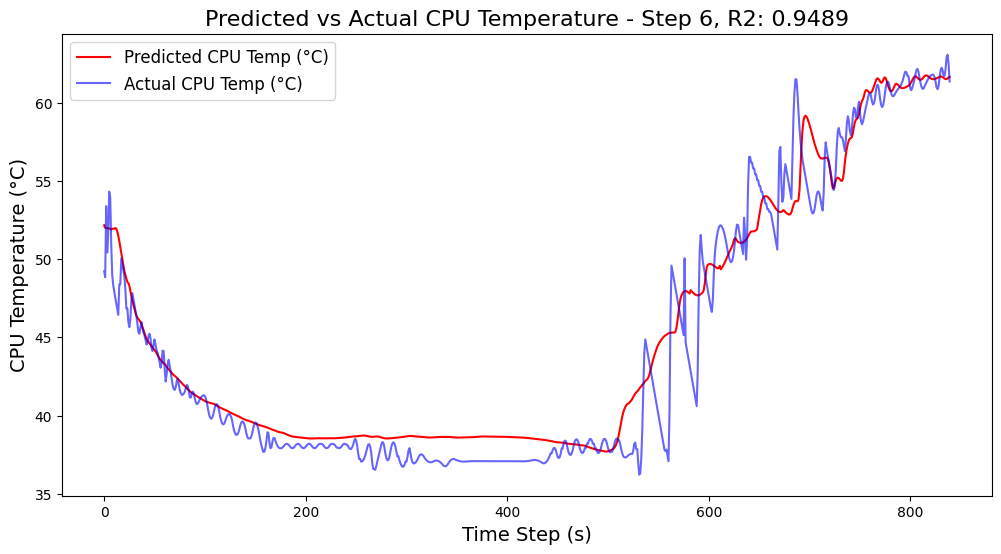

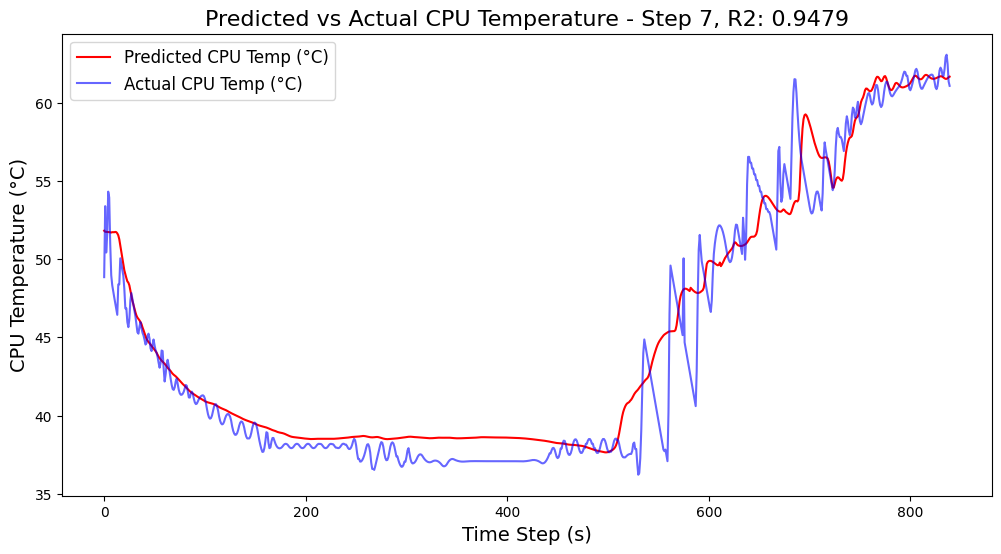

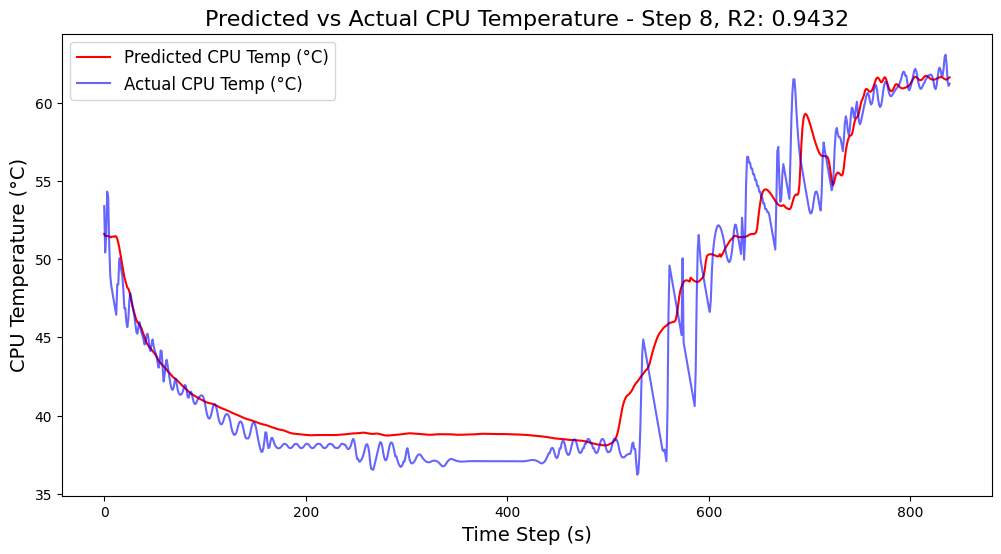

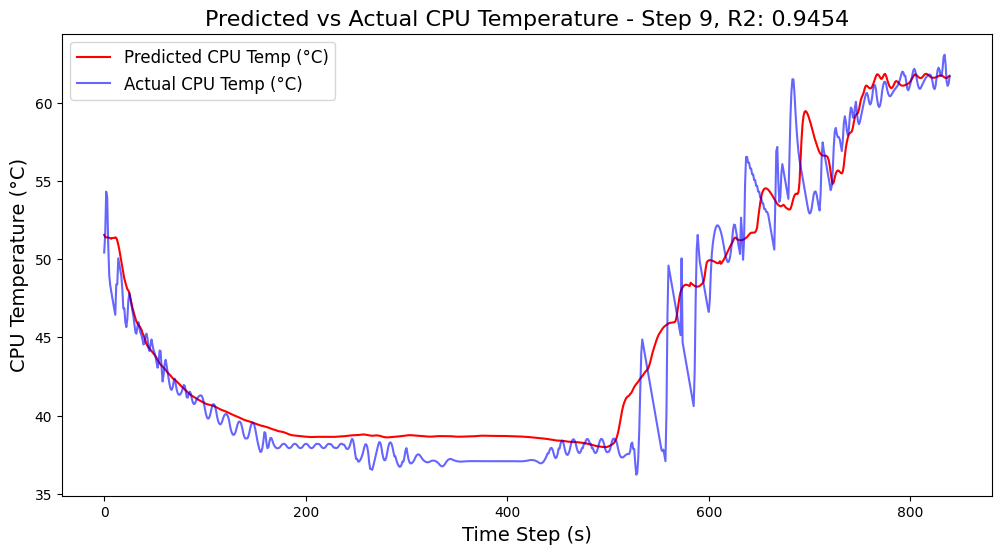

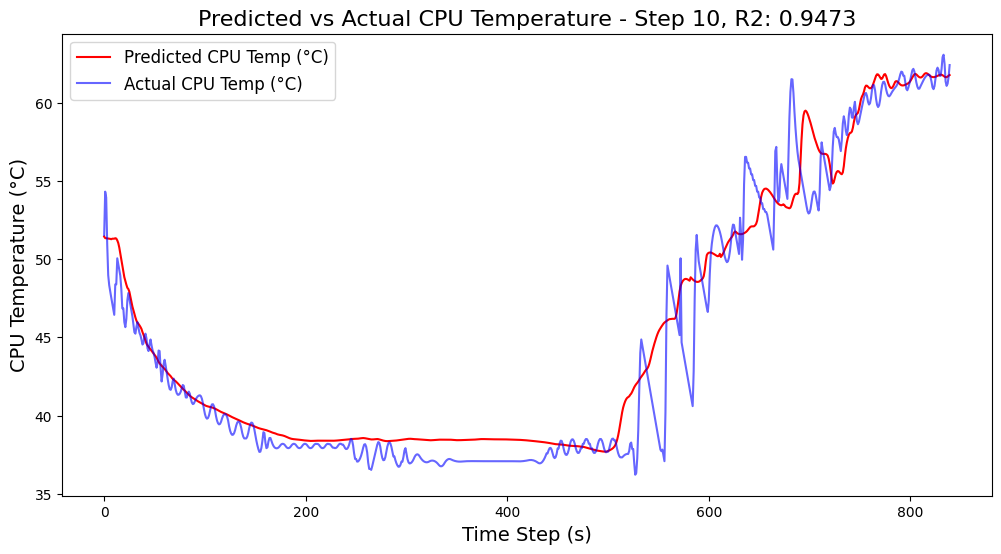

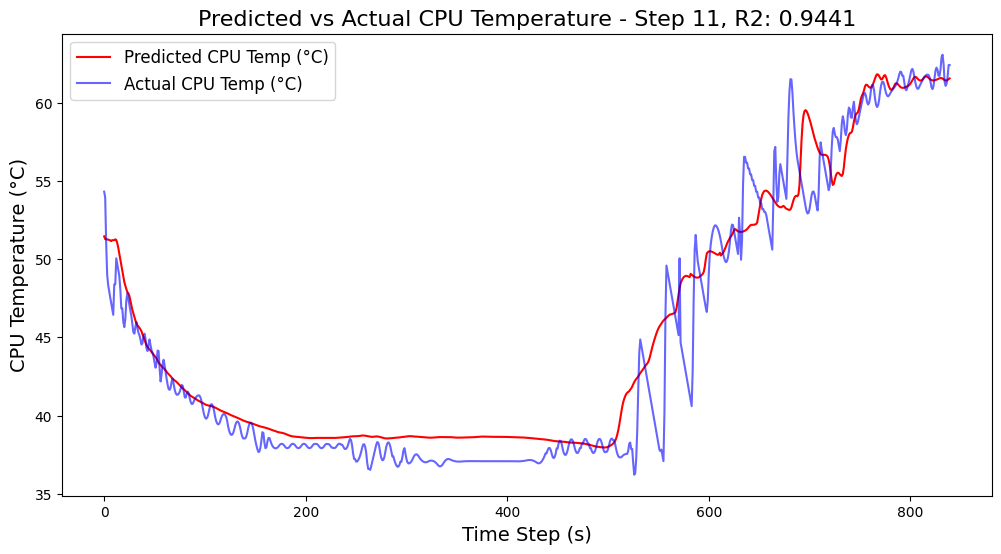

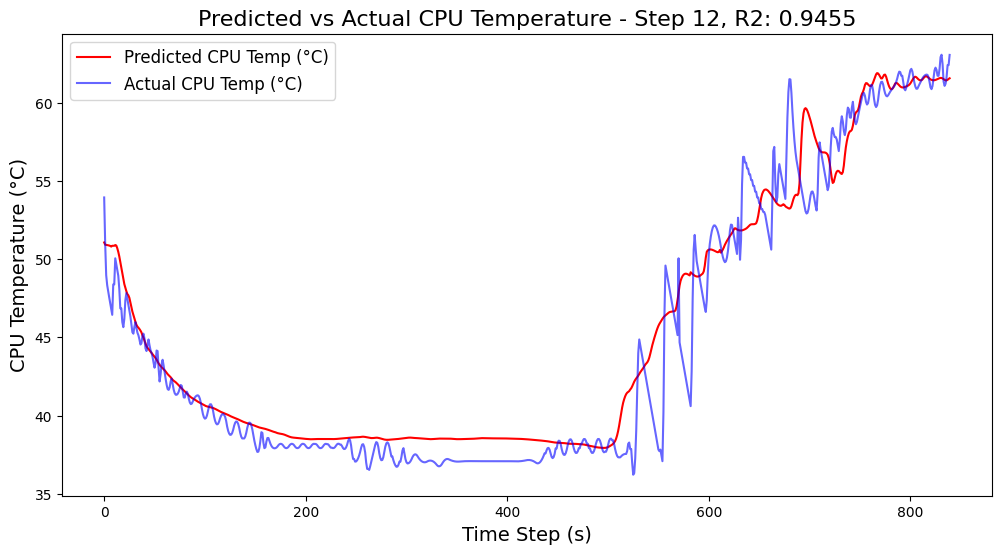

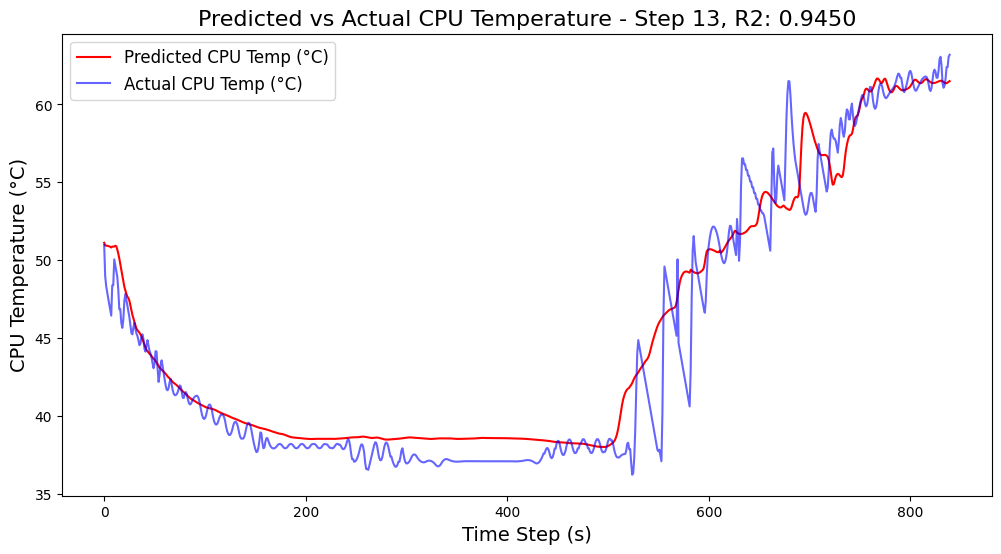

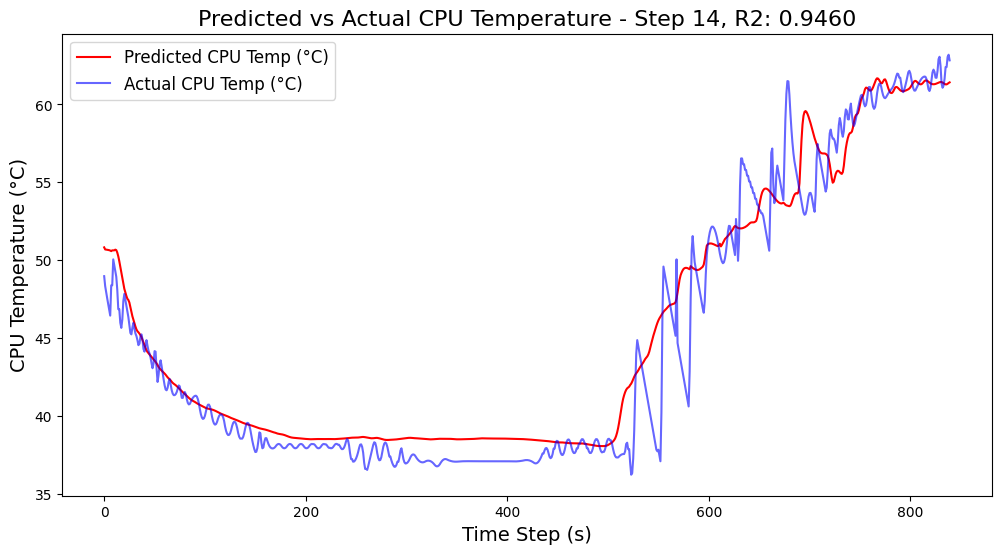

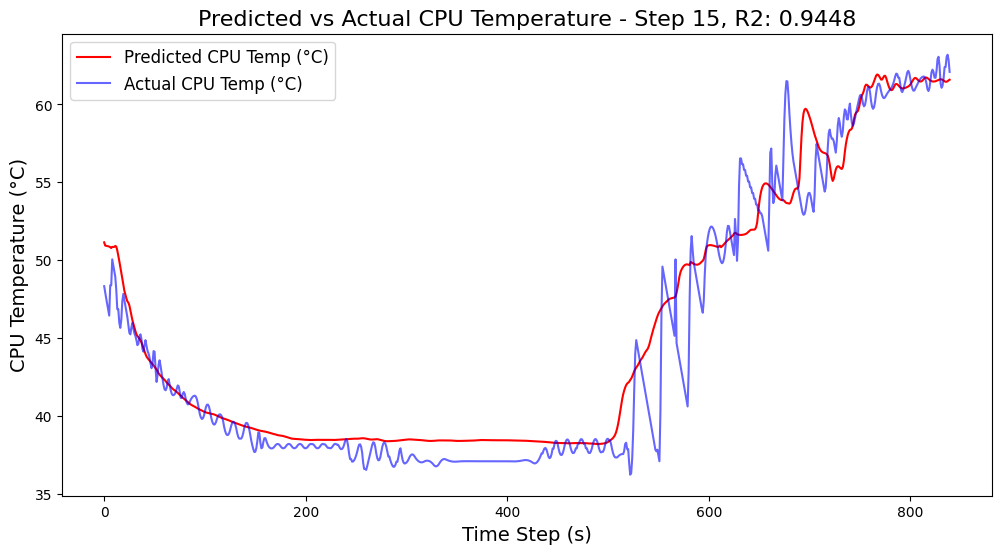

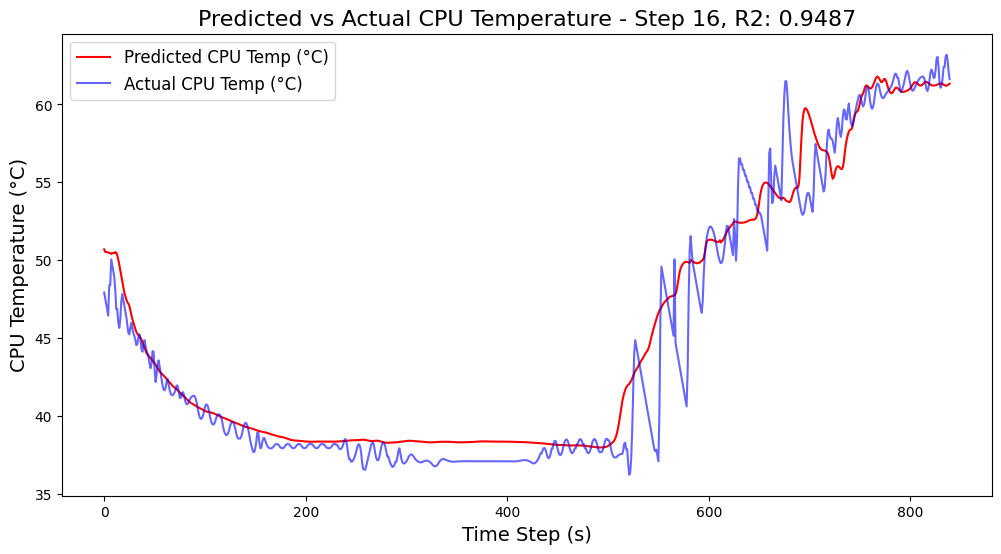

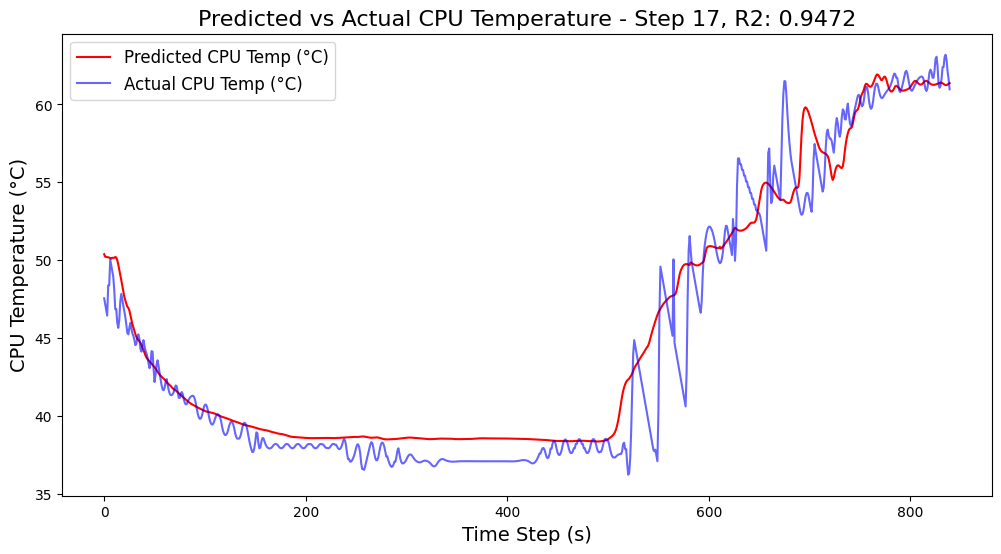

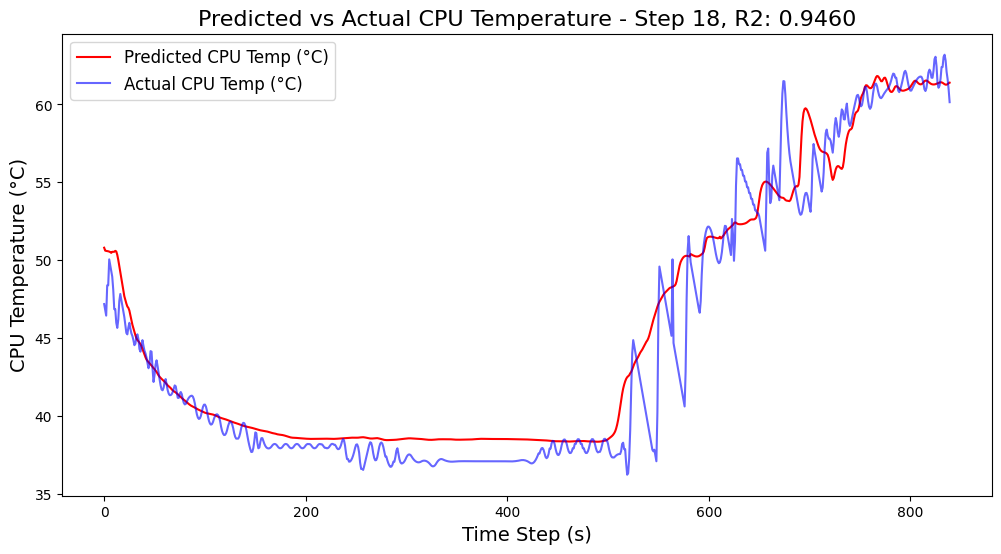

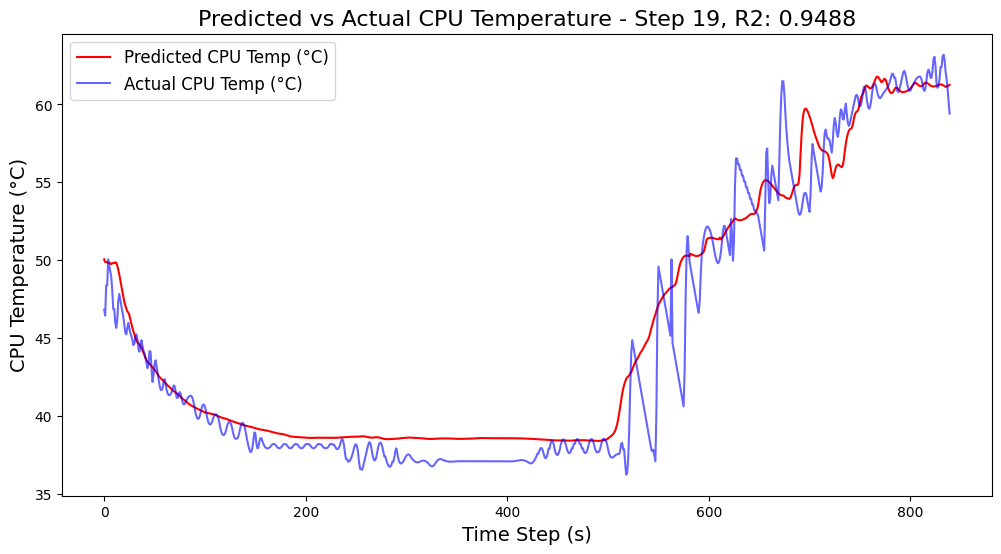

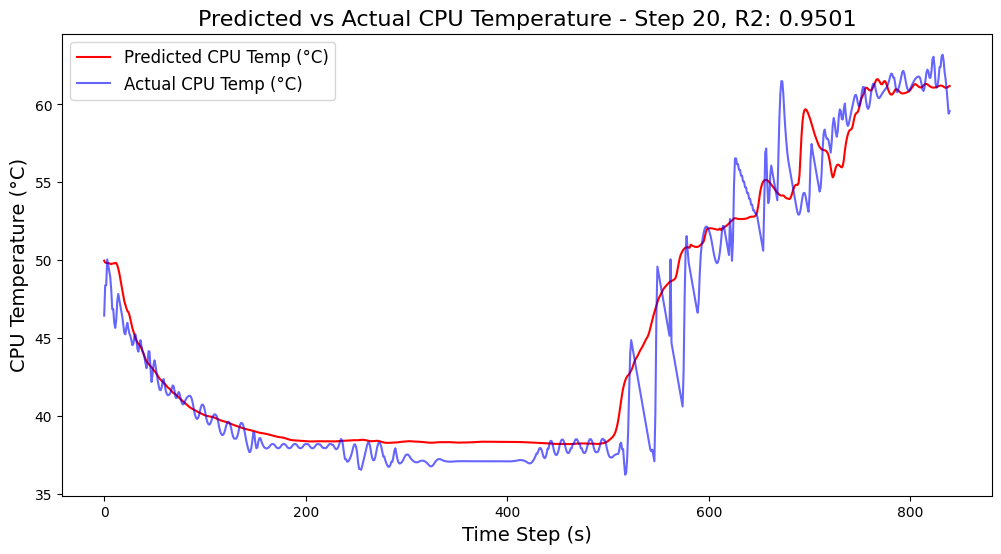

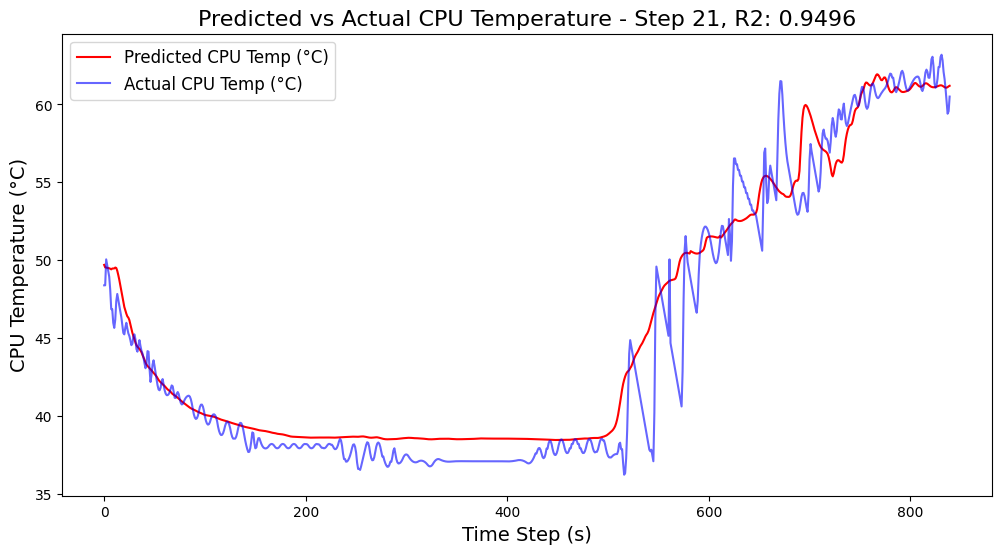

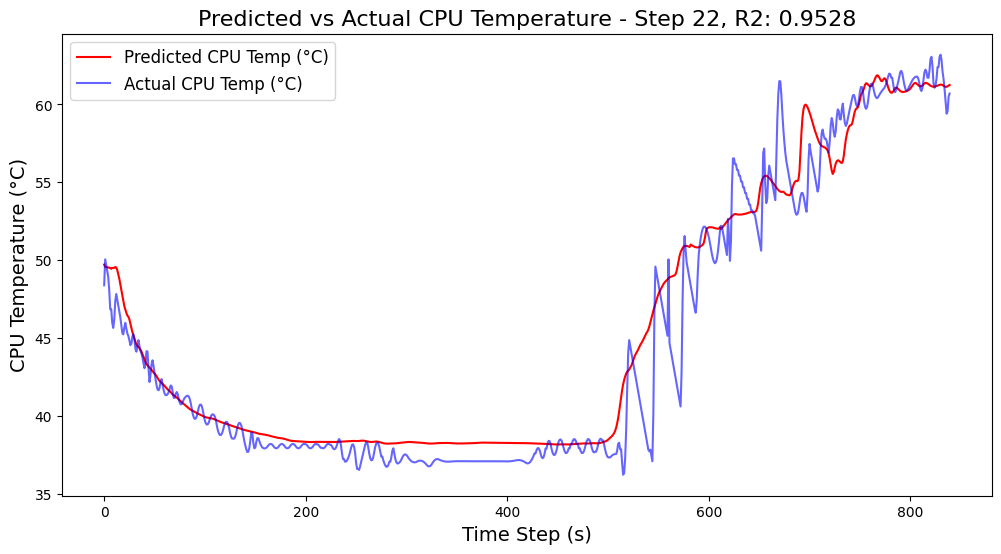

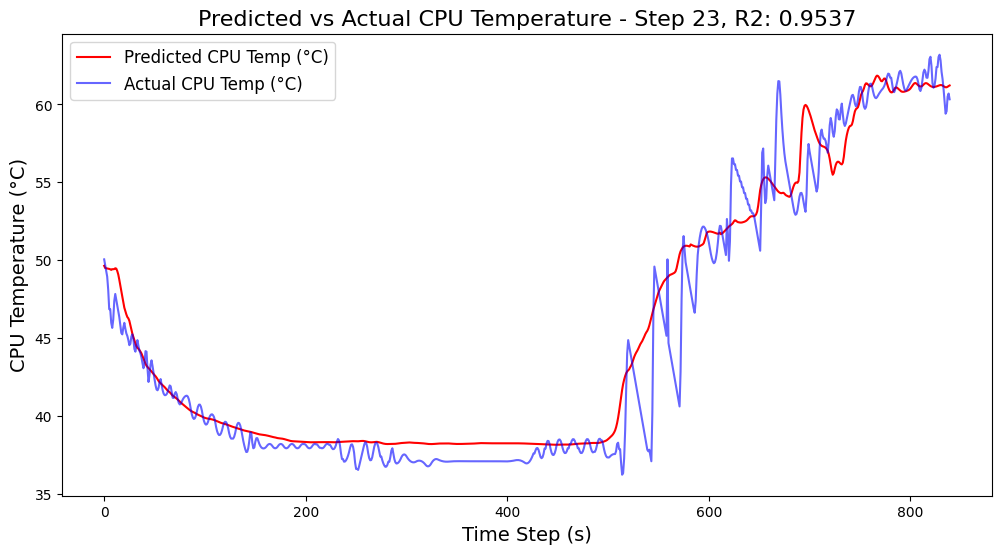

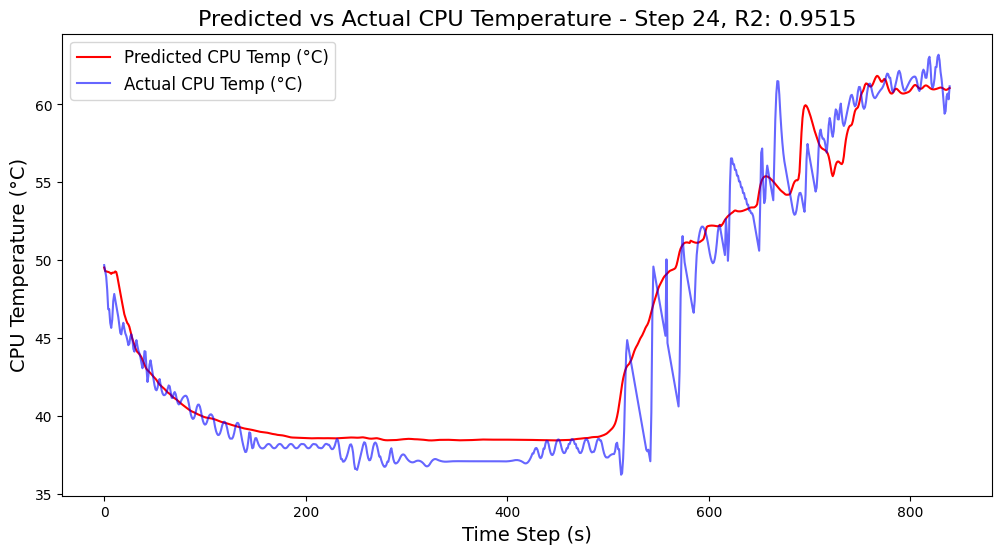

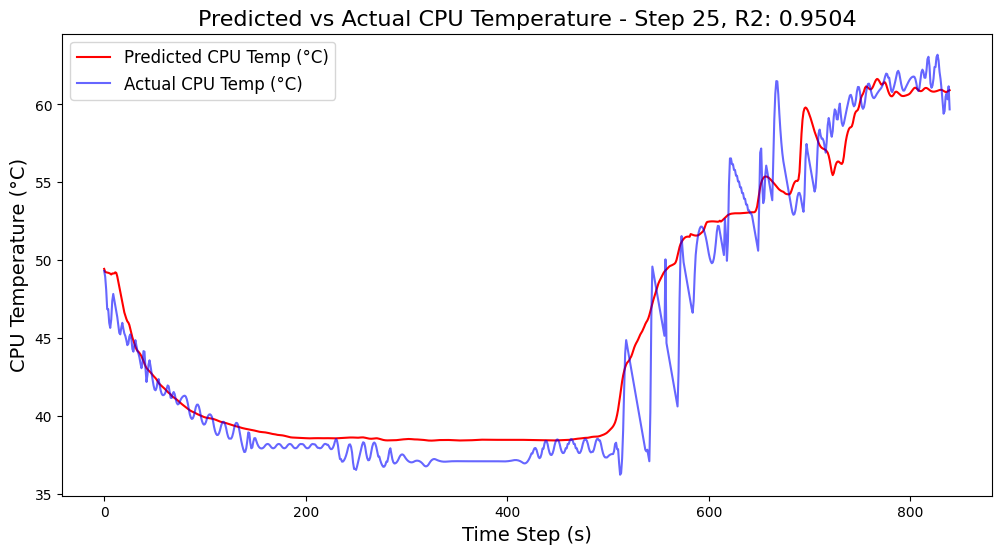

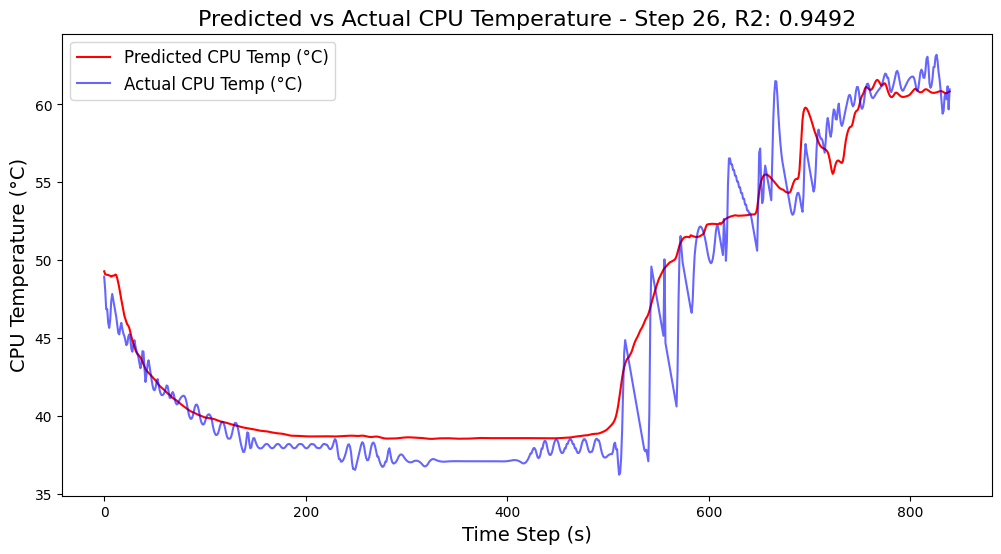

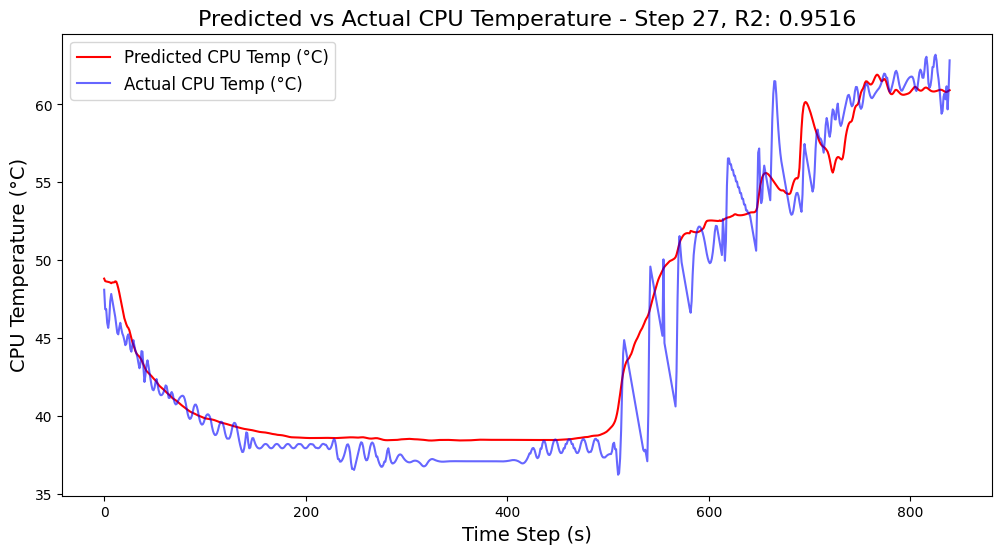

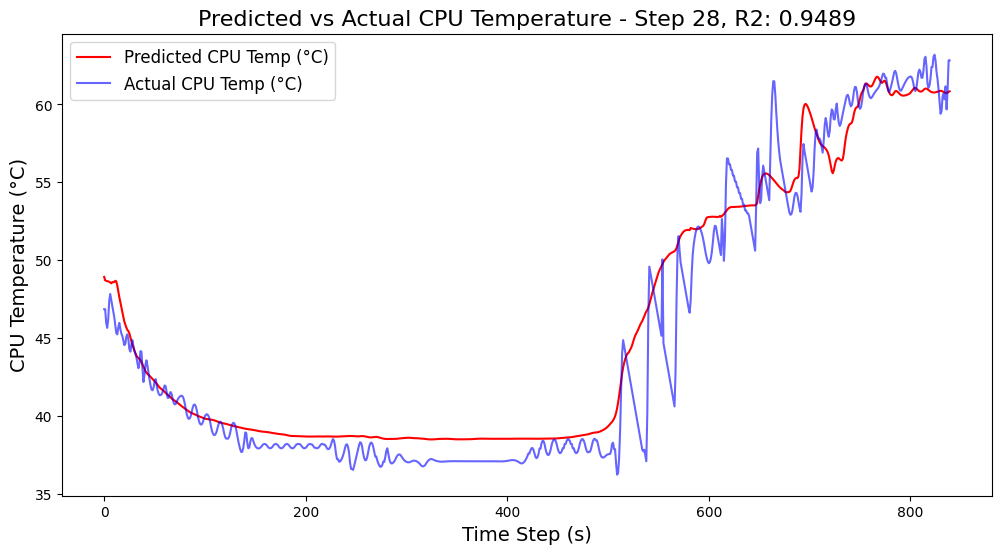

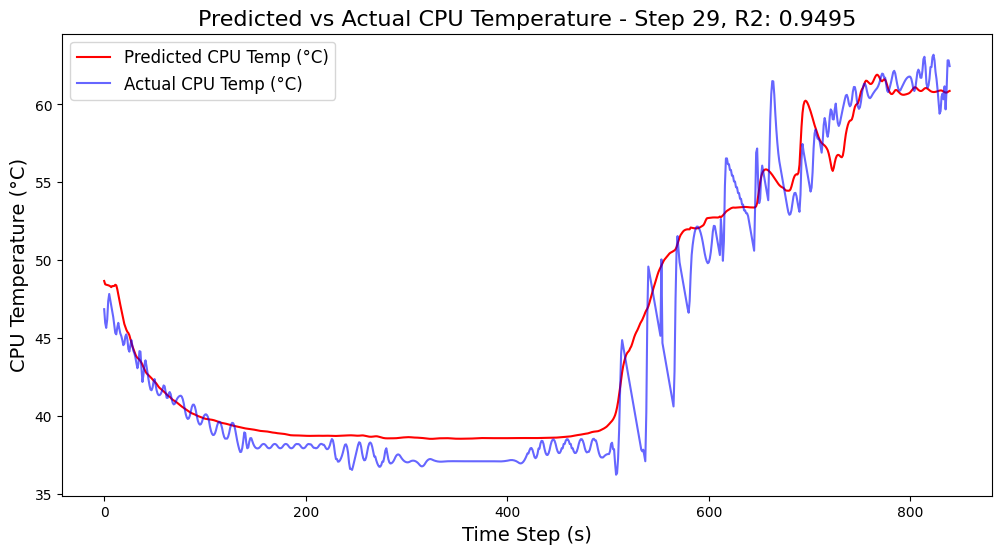

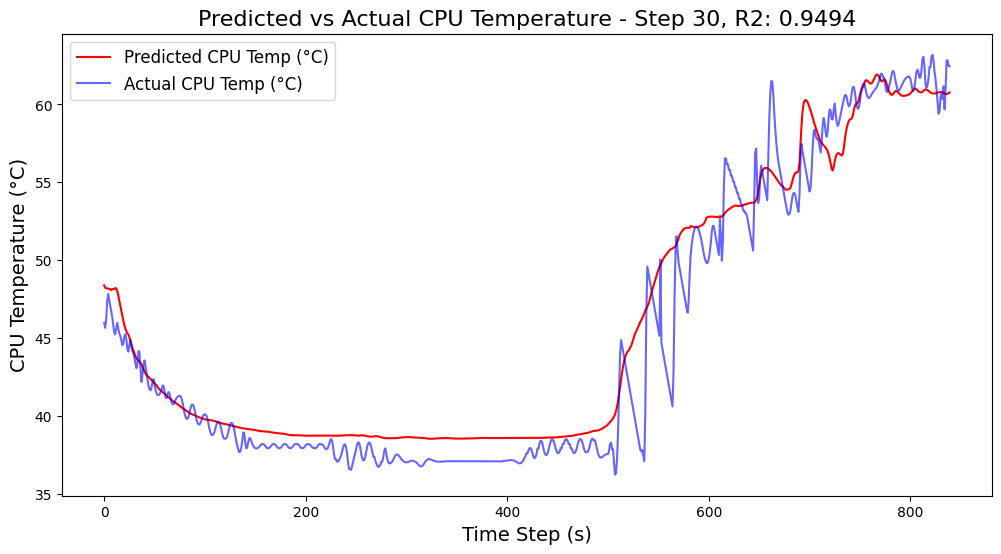

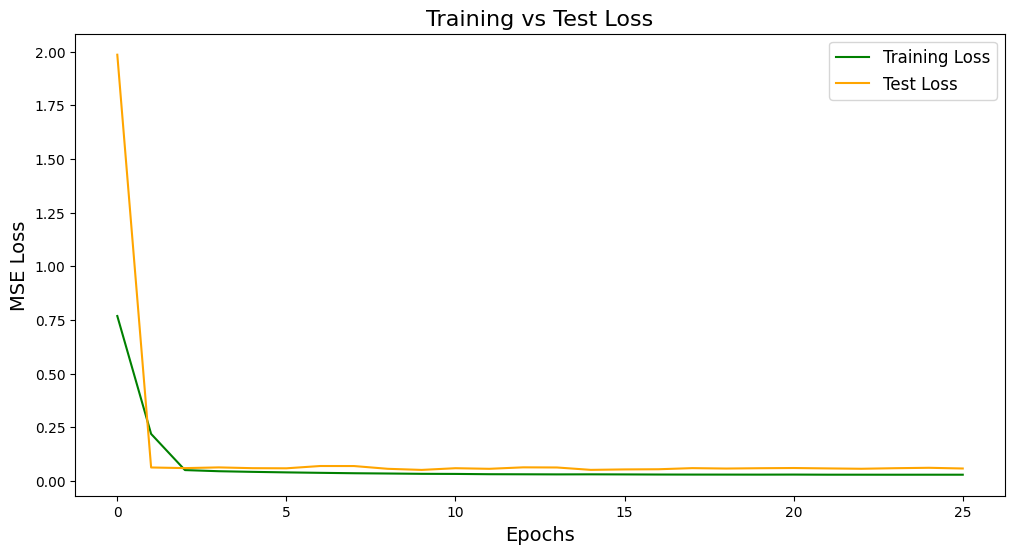

In [42]:
plot_results(predictions_df, history, k_step, r2_scores)